# Time Series Prediction with Built-in Dataset

This notebook demonstrates time series prediction using the Air Passengers dataset with comprehensive visualization.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the CO2 dataset (built-in statsmodels dataset)
data = co2.load_pandas()
df = data.data

# Clean the data - remove missing values
df = df.dropna()

# Convert to proper datetime index
df.index = pd.to_datetime(df.index)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())

Dataset shape: (2225, 1)
Date range: 1958-03-29 00:00:00 to 2001-12-29 00:00:00

First few rows:
              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4

Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2225 entries, 1958-03-29 to 2001-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 34.8 KB
None


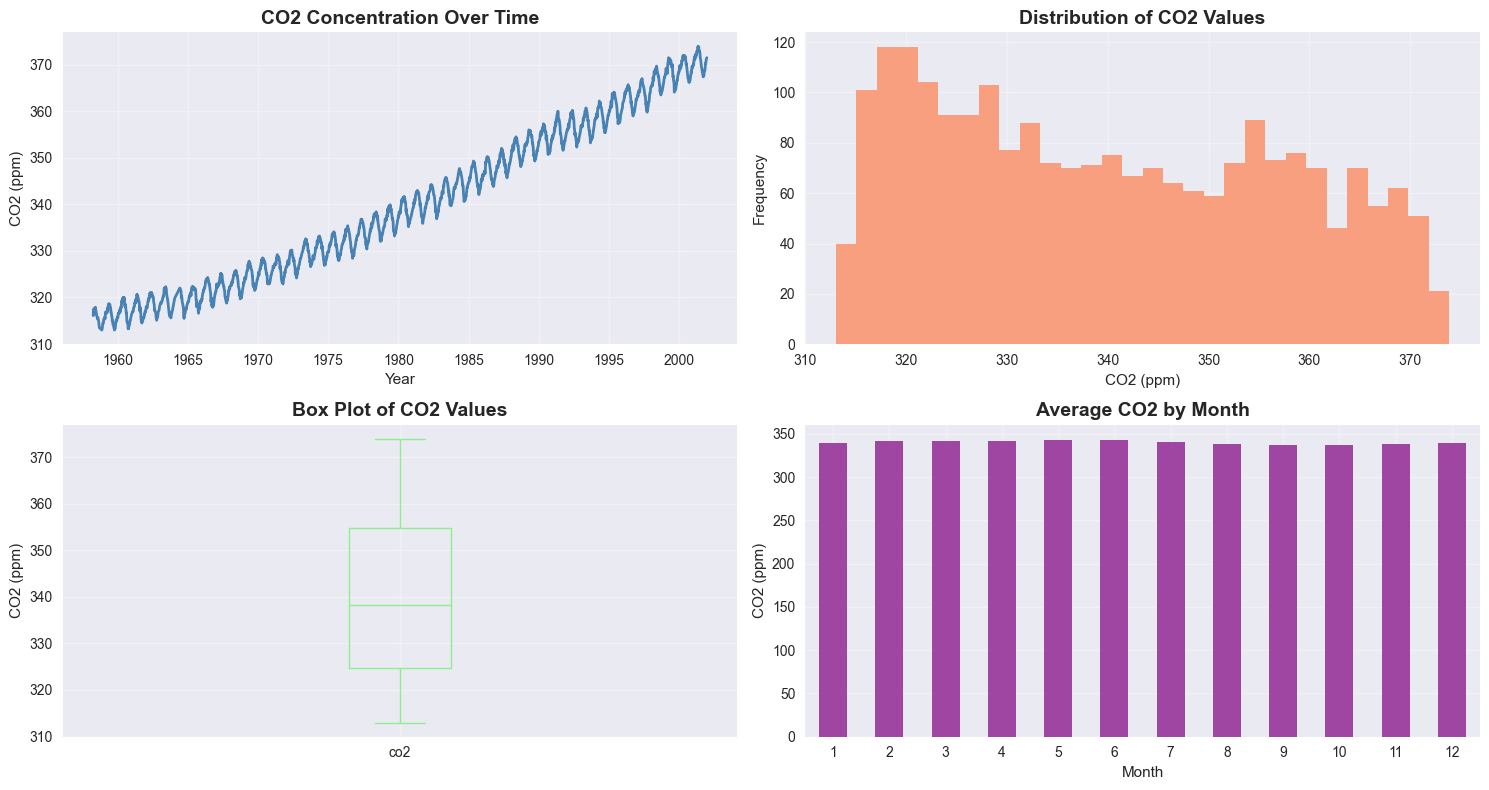

In [4]:
# Basic time series visualization
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(df.index, df['co2'], linewidth=2, color='steelblue')
plt.title('CO2 Concentration Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
df['co2'].hist(bins=30, alpha=0.7, color='coral')
plt.title('Distribution of CO2 Values', fontsize=14, fontweight='bold')
plt.xlabel('CO2 (ppm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
df['co2'].plot(kind='box', color='lightgreen')
plt.title('Box Plot of CO2 Values', fontsize=14, fontweight='bold')
plt.ylabel('CO2 (ppm)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Monthly pattern
monthly_avg = df.groupby(df.index.month)['co2'].mean()
monthly_avg.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Average CO2 by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('CO2 (ppm)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

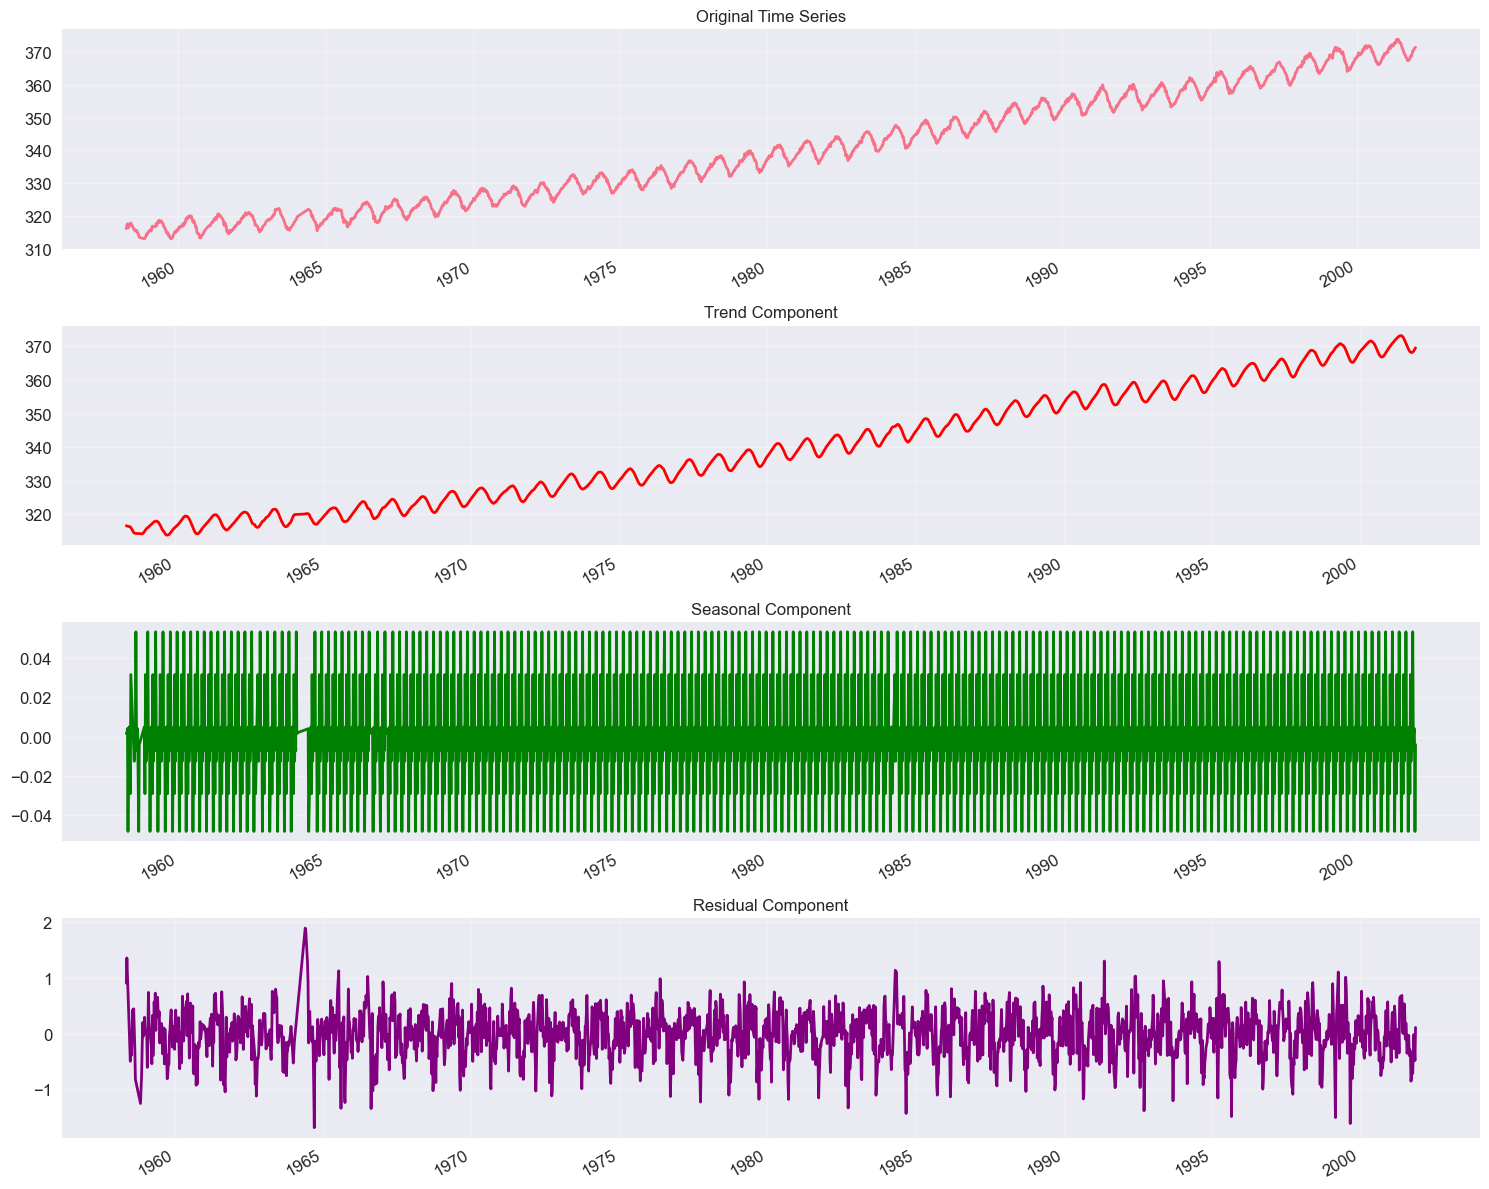

In [5]:
# Time series decomposition
decomposition = seasonal_decompose(df['co2'], model='additive', period=12)

plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
decomposition.observed.plot(title='Original Time Series', fontsize=12, linewidth=2)
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
decomposition.trend.plot(title='Trend Component', fontsize=12, linewidth=2, color='red')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
decomposition.seasonal.plot(title='Seasonal Component', fontsize=12, linewidth=2, color='green')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
decomposition.resid.plot(title='Residual Component', fontsize=12, linewidth=2, color='purple')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Stationarity test
def check_stationarity(ts, title):
    result = adfuller(ts.dropna())
    print(f'Results of Augmented Dickey-Fuller Test for {title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary\n")
    else:
        print("Result: Series is non-stationary\n")

# Test original series
check_stationarity(df['co2'], 'Original Series')

# First difference
df['co2_diff'] = df['co2'].diff()
check_stationarity(df['co2_diff'], 'First Difference')

Results of Augmented Dickey-Fuller Test for Original Series:
ADF Statistic: 0.043965
p-value: 0.962020
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Result: Series is non-stationary

Results of Augmented Dickey-Fuller Test for First Difference:
ADF Statistic: -15.717216
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Result: Series is stationary



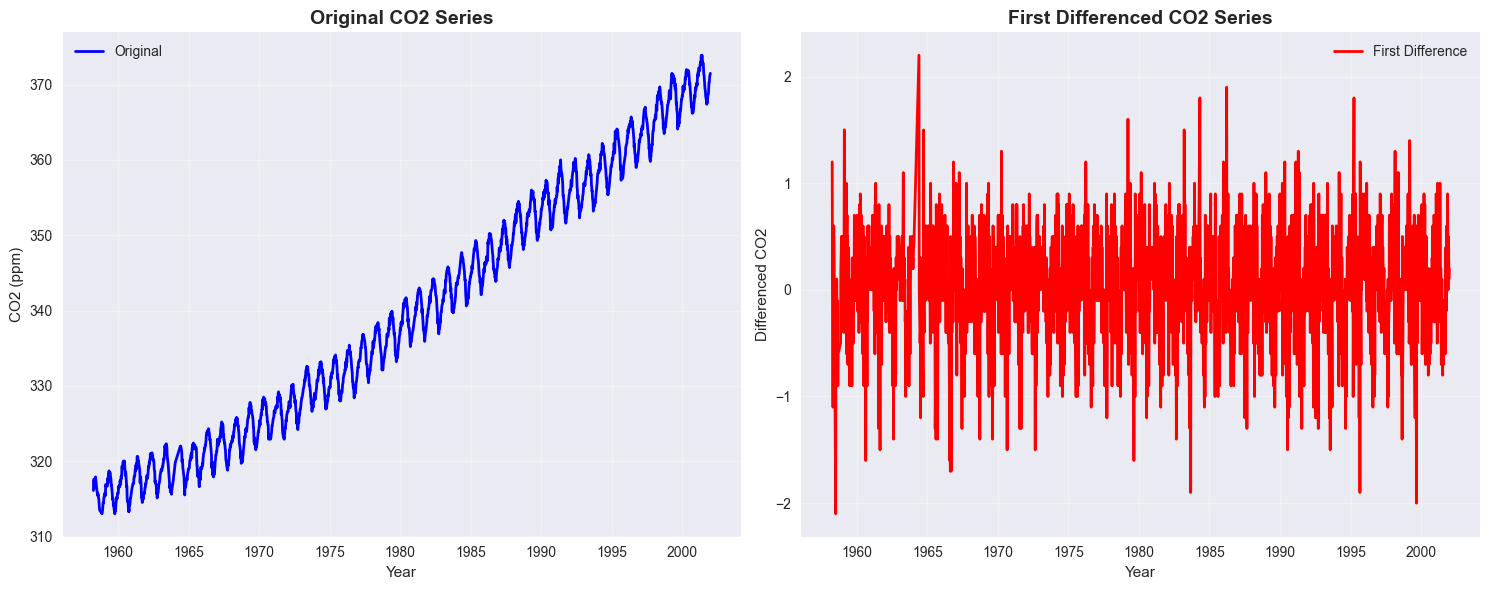

In [7]:
# Visualize differenced series
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df.index, df['co2'], linewidth=2, color='blue', label='Original')
plt.title('Original CO2 Series', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(df.index, df['co2_diff'], linewidth=2, color='red', label='First Difference')
plt.title('First Differenced CO2 Series', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Differenced CO2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Training set size: 1780
Test set size: 445
Training period: 1958-03-29 00:00:00 to 1993-06-19 00:00:00
Test period: 1993-06-26 00:00:00 to 2001-12-29 00:00:00


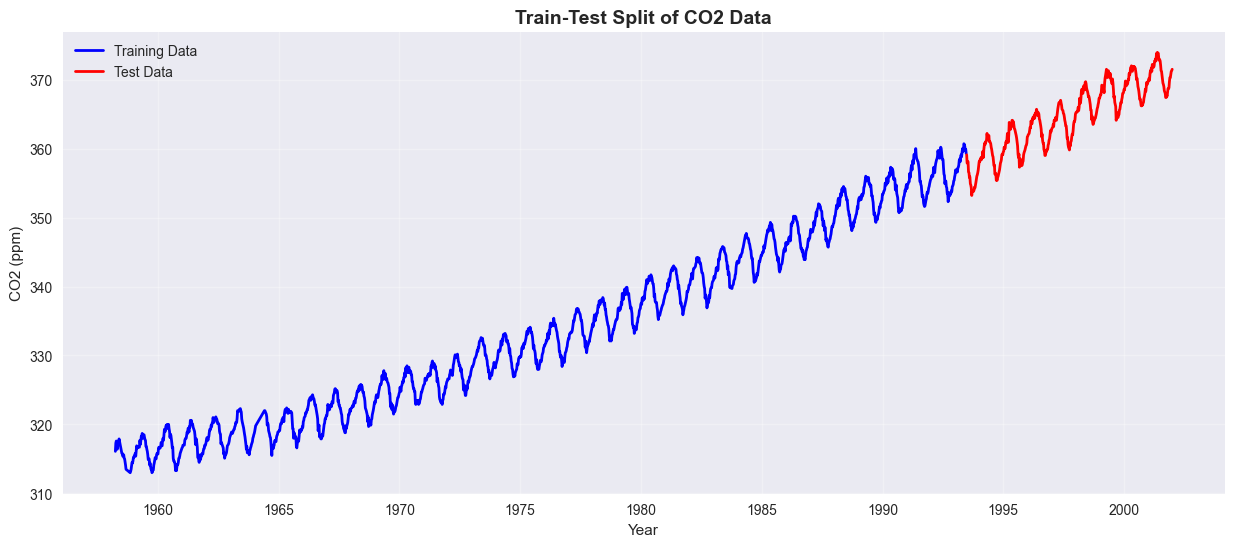

In [8]:
# Split data for training and testing
train_size = int(len(df) * 0.8)
train, test = df['co2'][:train_size], df['co2'][train_size:]

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")
print(f"Training period: {train.index.min()} to {train.index.max()}")
print(f"Test period: {test.index.min()} to {test.index.max()}")

# Visualize train-test split
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=2, color='blue')
plt.plot(test.index, test, label='Test Data', linewidth=2, color='red')
plt.title('Train-Test Split of CO2 Data', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# ARIMA Model
# Fit ARIMA model
model = ARIMA(train, order=(1, 1, 1))
fitted_model = model.fit()

print(fitted_model.summary())

# Make predictions
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)
forecast_index = test.index

# Calculate confidence intervals
forecast_result = fitted_model.get_forecast(steps=forecast_steps)
conf_int = forecast_result.conf_int()

print(f"\nForecast completed for {forecast_steps} periods")

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                 1780
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1216.040
Date:                Sun, 15 Jun 2025   AIC                           2438.079
Time:                        15:25:04   BIC                           2454.531
Sample:                             0   HQIC                          2444.156
                               - 1780                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8903      0.026     34.032      0.000       0.839       0.942
ma.L1         -0.7540      0.039    -19.359      0.000      -0.830      -0.678
sigma2         0.2297      0.007     34.571      0.0

Model Performance Metrics:
MSE: 59.9027
RMSE: 7.7397
MAE: 6.5426
MAPE: nan%


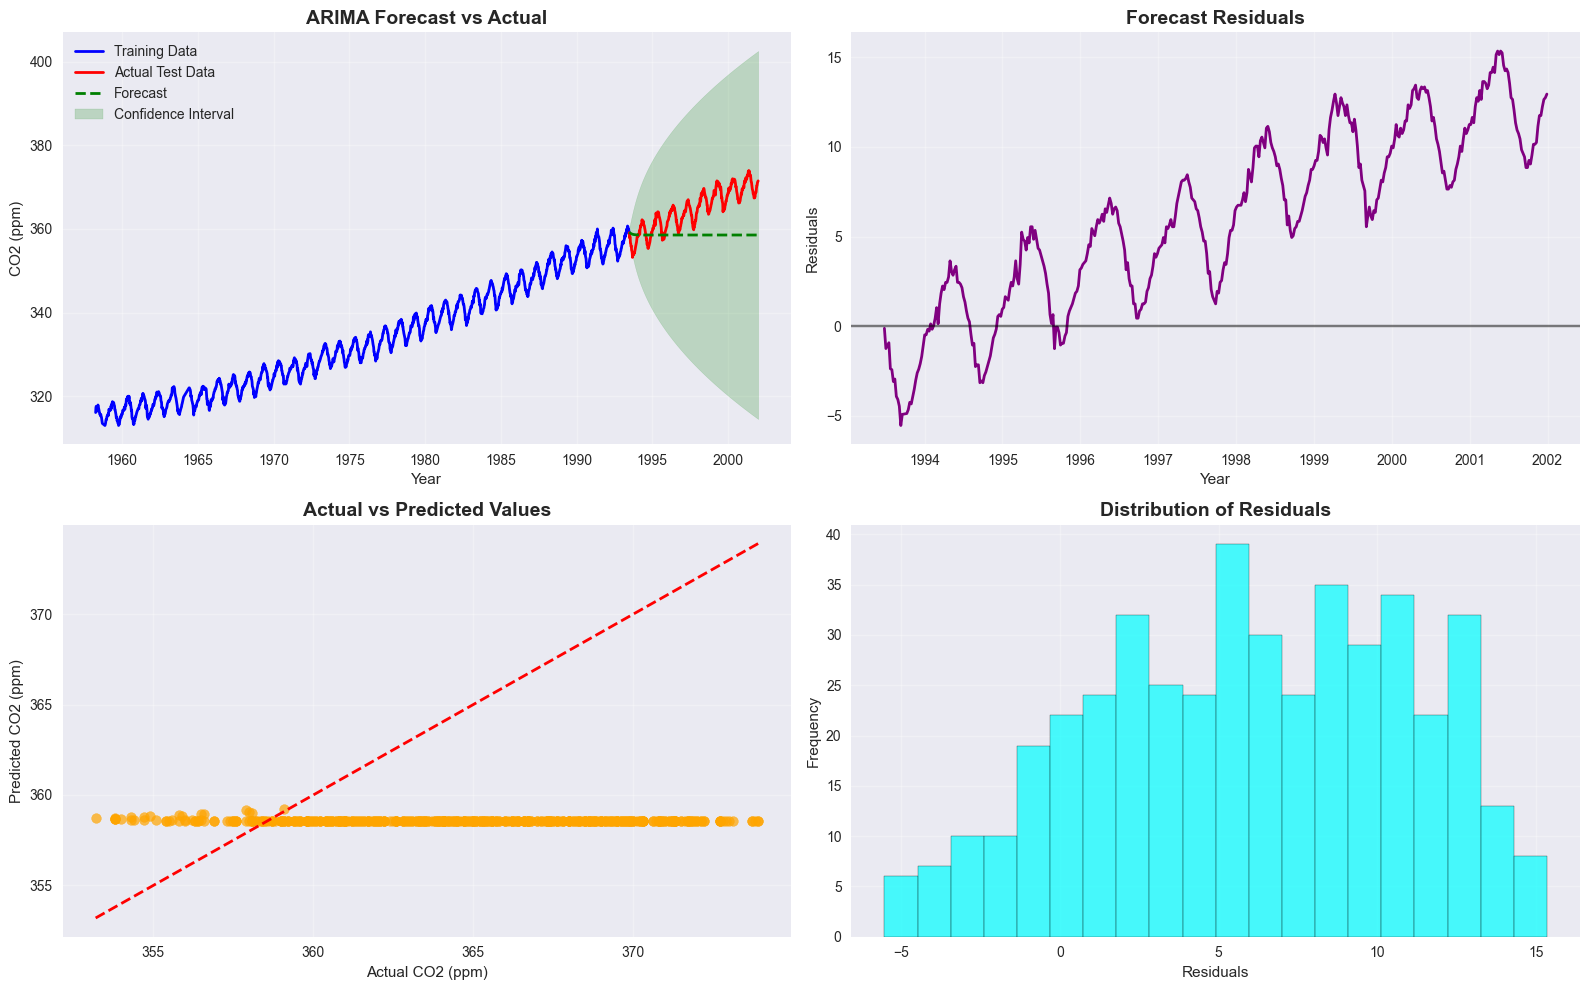

In [14]:
# Calculate metrics
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# Create a comprehensive forecast visualization
plt.figure(figsize=(16, 10))

# Main forecast plot
plt.subplot(2, 2, 1)
plt.plot(train.index, train, label='Training Data', linewidth=2, color='blue')
plt.plot(test.index, test, label='Actual Test Data', linewidth=2, color='red')
plt.plot(forecast_index, forecast, label='Forecast', linewidth=2, color='green', linestyle='--')
plt.fill_between(forecast_index, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color='green', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(2, 2, 2)
forecast_residuals = test.values - forecast.values
plt.plot(test.index, forecast_residuals, linewidth=2, color='purple')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title('Forecast Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Scatter plot: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(test, forecast, alpha=0.7, color='orange')
plt.plot([test.min(), test.max()], [test.min(), test.max()], 'r--', linewidth=2)
plt.title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
plt.xlabel('Actual CO2 (ppm)')
plt.ylabel('Predicted CO2 (ppm)')
plt.grid(True, alpha=0.3)

# Histogram of residuals
plt.subplot(2, 2, 4)
plt.hist(forecast_residuals[~np.isnan(forecast_residuals)], bins=20, alpha=0.7, color='cyan', edgecolor='black')
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

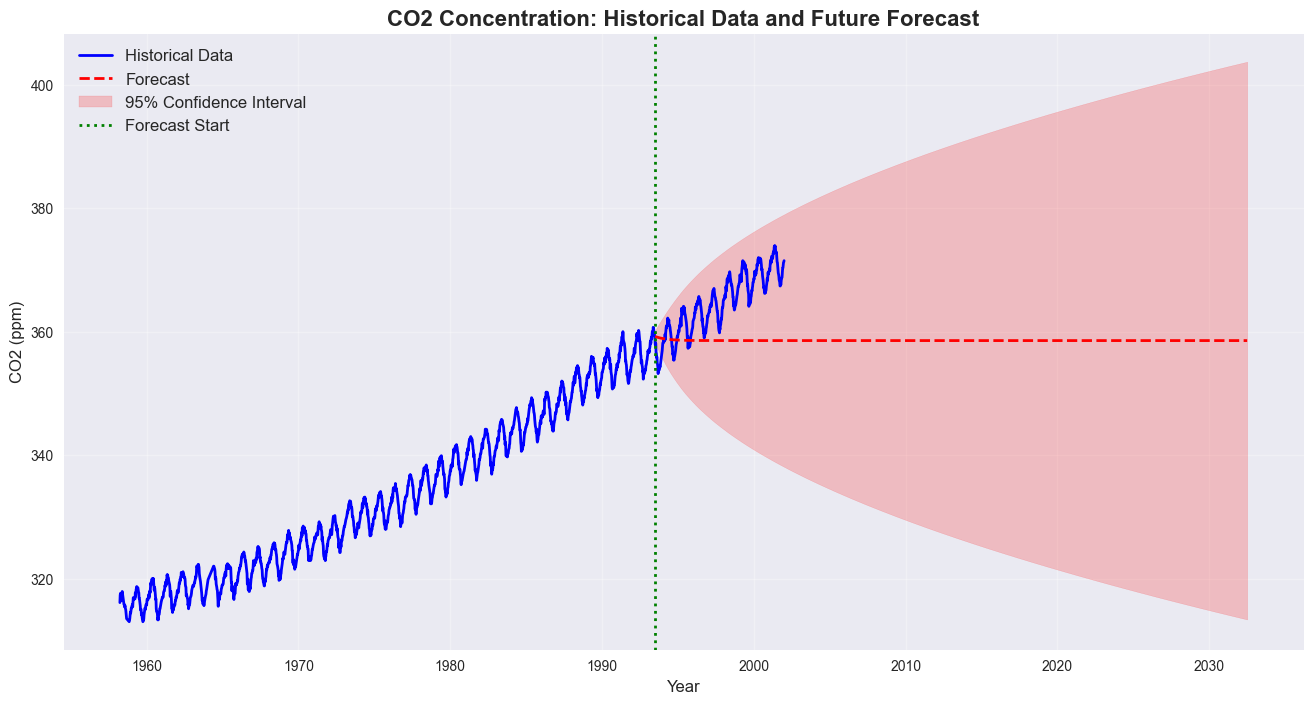


Future Forecast (next 24 months after test period):
2030-08: 358.55 ppm
2030-09: 358.55 ppm
2030-10: 358.55 ppm
2030-11: 358.55 ppm
2030-12: 358.55 ppm
2031-01: 358.55 ppm
2031-02: 358.55 ppm
2031-03: 358.55 ppm
2031-04: 358.55 ppm
2031-05: 358.55 ppm
2031-06: 358.55 ppm
2031-07: 358.55 ppm


In [15]:
# Future predictions beyond the test set
future_steps = 24  # Predict 24 months into the future
future_forecast = fitted_model.forecast(steps=len(test) + future_steps)
future_result = fitted_model.get_forecast(steps=len(test) + future_steps)
future_conf_int = future_result.conf_int()

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=test.index[0], periods=len(test) + future_steps, freq='MS')

# Extended forecast visualization
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df.index, df['co2'], label='Historical Data', linewidth=2, color='blue')

# Plot forecast
plt.plot(future_dates, future_forecast, label='Forecast', linewidth=2, color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(future_dates, 
                future_conf_int.iloc[:, 0], 
                future_conf_int.iloc[:, 1], 
                color='red', alpha=0.2, label='95% Confidence Interval')

# Add vertical line to separate historical from forecast
plt.axvline(x=train.index[-1], color='green', linestyle=':', linewidth=2, label='Forecast Start')

plt.title('CO2 Concentration: Historical Data and Future Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print future forecast values
print("\nFuture Forecast (next 24 months after test period):")
future_only = future_forecast[len(test):]
future_dates_only = future_dates[len(test):]

for date, value in zip(future_dates_only[:12], future_only[:12]):  # Show first 12 future predictions
    print(f"{date.strftime('%Y-%m')}: {value:.2f} ppm")

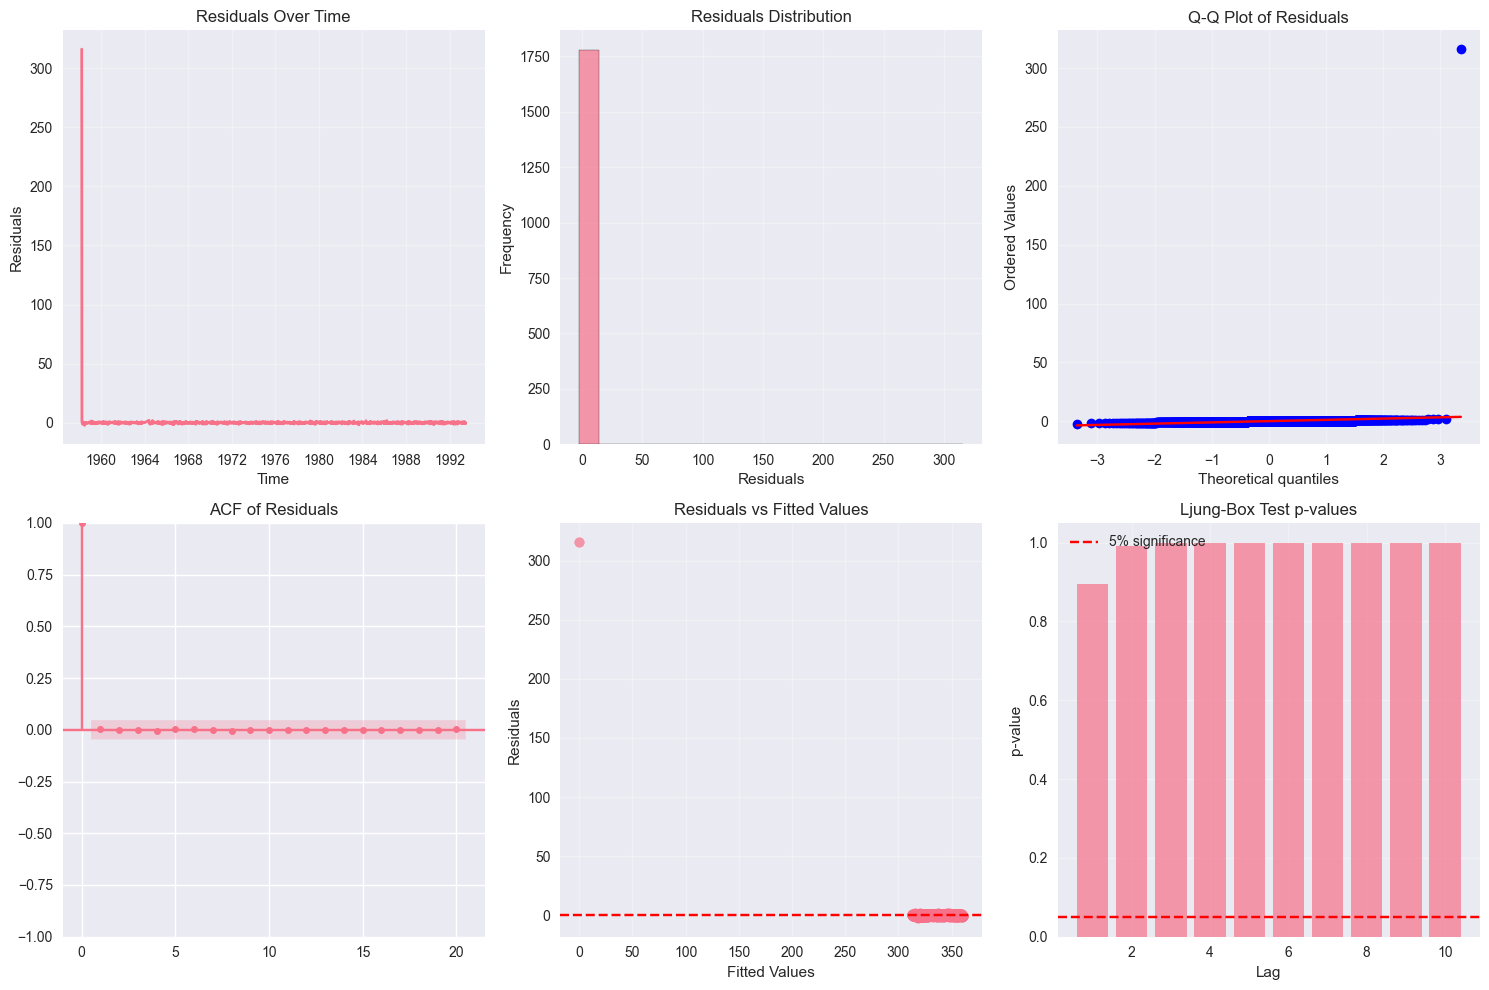

Model Diagnostics Summary:
Mean of residuals: 0.188085
Standard deviation of residuals: 7.505244
Ljung-Box test p-value (lag 10): 1.000000
Residuals appear to be white noise (good!)


In [16]:
# Model diagnostics
plt.figure(figsize=(15, 10))

# Residual diagnostics
residuals = fitted_model.resid

plt.subplot(2, 3, 1)
plt.plot(residuals, linewidth=2)
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(2, 3, 5)
fitted_values = fitted_model.fittedvalues
plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
# Ljung-Box test results
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_stat = acorr_ljungbox(residuals, lags=10, return_df=True)
plt.bar(range(1, 11), lb_stat['lb_pvalue'], alpha=0.7)
plt.axhline(y=0.05, color='red', linestyle='--', label='5% significance')
plt.title('Ljung-Box Test p-values')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model Diagnostics Summary:")
print(f"Mean of residuals: {np.mean(residuals):.6f}")
print(f"Standard deviation of residuals: {np.std(residuals):.6f}")
print(f"Ljung-Box test p-value (lag 10): {lb_stat['lb_pvalue'].iloc[9]:.6f}")
if lb_stat['lb_pvalue'].iloc[9] > 0.05:
    print("Residuals appear to be white noise (good!)")
else:
    print("Residuals may have remaining autocorrelation")

# Prophet Model

In [19]:
# Add this cell after the existing Prophet Model markdown cell

# Install and import Prophet
try:
    from prophet import Prophet
    print("Prophet imported successfully!")
except ImportError:
    print("Installing Prophet...")
    import subprocess
    subprocess.check_call(["pip", "install", "prophet"])
    from prophet import Prophet
    print("Prophet installed and imported successfully!")

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_df = pd.DataFrame({
    'ds': df.index,
    'y': df['co2'].values
})

# Split data for Prophet
prophet_train = prophet_df[:train_size]
prophet_test = prophet_df[train_size:]

print(f"Prophet training data shape: {prophet_train.shape}")
print(f"Prophet test data shape: {prophet_test.shape}")
print("\nFirst few rows of Prophet training data:")
print(prophet_train.head())

Prophet imported successfully!
Prophet training data shape: (1780, 2)
Prophet test data shape: (445, 2)

First few rows of Prophet training data:
          ds      y
0 1958-03-29  316.1
1 1958-04-05  317.3
2 1958-04-12  317.6
3 1958-04-19  317.5
4 1958-04-26  316.4


In [21]:
# Initialize and fit Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

print("Fitting Prophet model...")
prophet_model.fit(prophet_train)
print("Prophet model fitted successfully!")

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='MS')
print(f"Future dataframe shape: {future.shape}")
print(f"Future date range: {future['ds'].min()} to {future['ds'].max()}")

15:33:38 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet model...


15:33:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully!
Future dataframe shape: (2225, 1)
Future date range: 1958-03-29 00:00:00 to 2030-07-01 00:00:00


In [22]:
# Make predictions with Prophet
prophet_forecast = prophet_model.predict(future)

# Extract test period predictions
prophet_test_pred = prophet_forecast[train_size:]

# Calculate Prophet metrics
prophet_mse = mean_squared_error(test.values, prophet_test_pred['yhat'].values)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(test.values, prophet_test_pred['yhat'].values)
prophet_mape = np.mean(np.abs((test.values - prophet_test_pred['yhat'].values) / test.values)) * 100

print("Prophet Model Performance Metrics:")
print(f"MSE: {prophet_mse:.4f}")
print(f"RMSE: {prophet_rmse:.4f}")
print(f"MAE: {prophet_mae:.4f}")
print(f"MAPE: {prophet_mape:.2f}%")

# Compare with ARIMA metrics
print("\nComparison with ARIMA:")
print(f"ARIMA RMSE: {rmse:.4f} | Prophet RMSE: {prophet_rmse:.4f}")
print(f"ARIMA MAE: {mae:.4f} | Prophet MAE: {prophet_mae:.4f}")
print(f"ARIMA MAPE: {mape:.2f}% | Prophet MAPE: {prophet_mape:.2f}%")

Prophet Model Performance Metrics:
MSE: 578.3302
RMSE: 24.0485
MAE: 20.9448
MAPE: 5.71%

Comparison with ARIMA:
ARIMA RMSE: 7.7397 | Prophet RMSE: 24.0485
ARIMA MAE: 6.5426 | Prophet MAE: 20.9448
ARIMA MAPE: nan% | Prophet MAPE: 5.71%


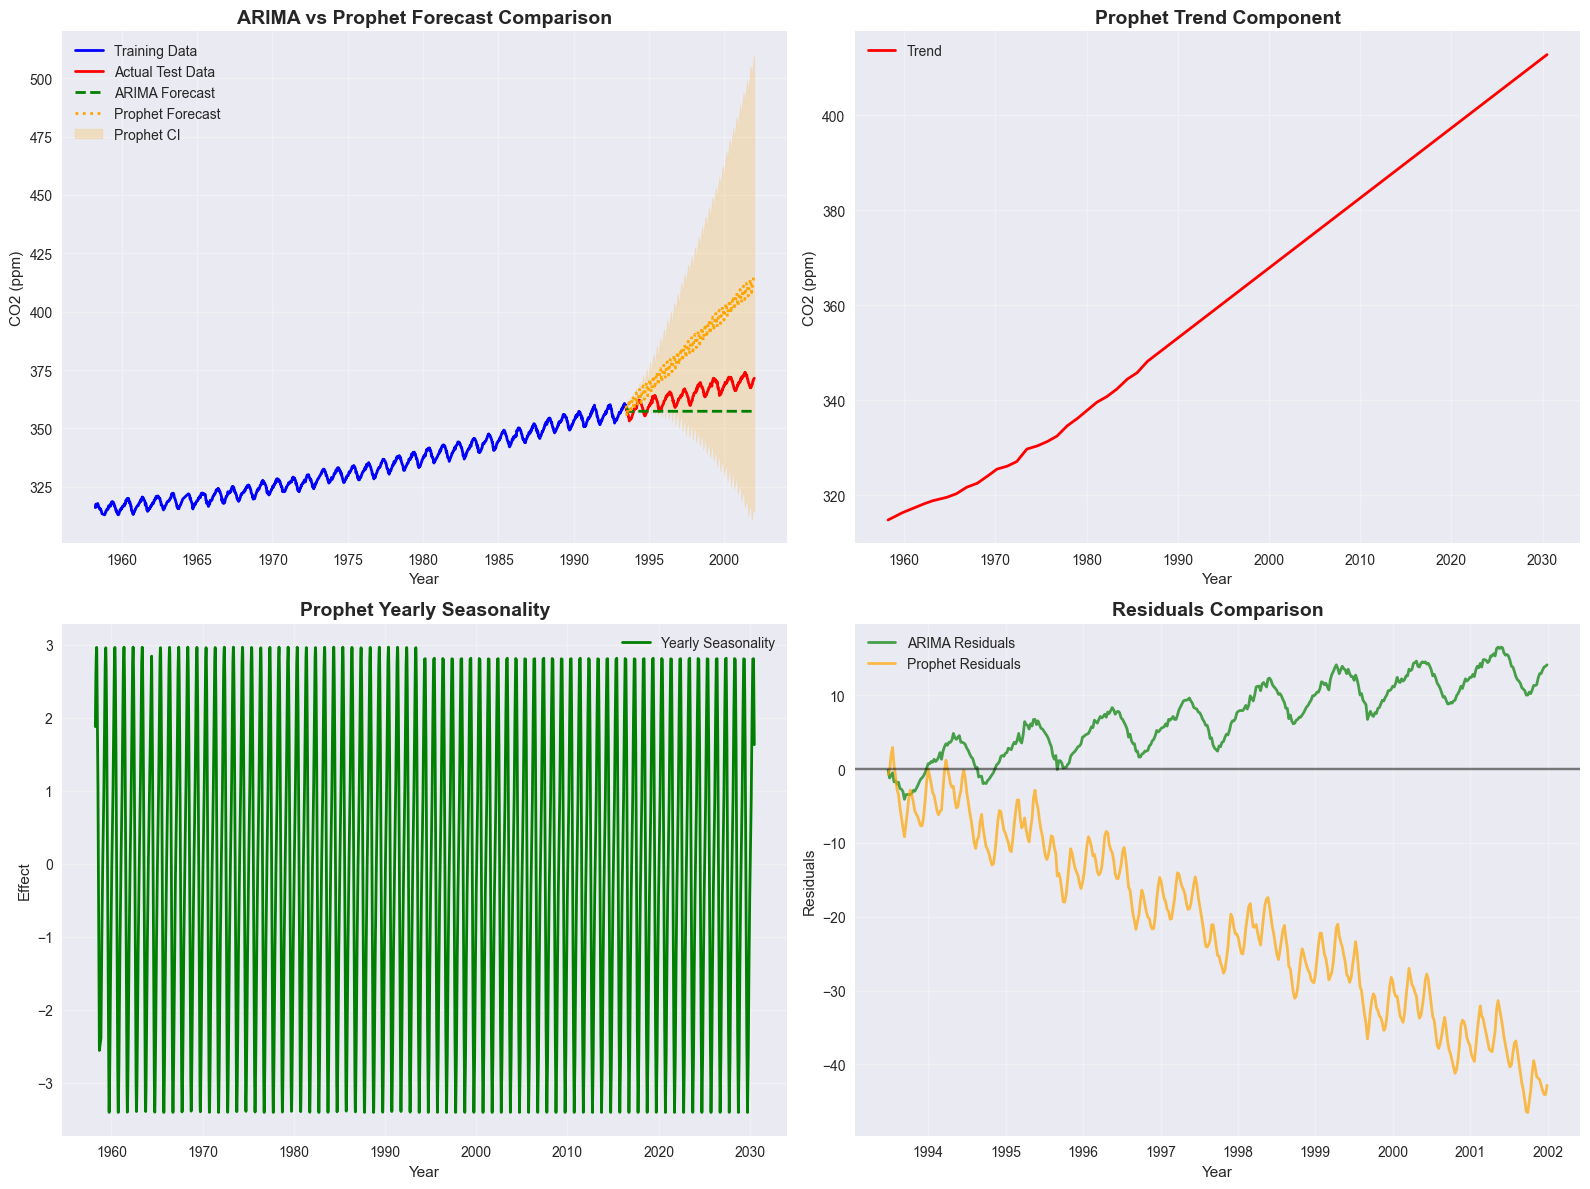

In [23]:
# Prophet forecast visualization
plt.figure(figsize=(16, 12))

# Main forecast comparison
plt.subplot(2, 2, 1)
plt.plot(train.index, train, label='Training Data', linewidth=2, color='blue')
plt.plot(test.index, test, label='Actual Test Data', linewidth=2, color='red')
plt.plot(test.index, forecast, label='ARIMA Forecast', linewidth=2, color='green', linestyle='--')
plt.plot(test.index, prophet_test_pred['yhat'], label='Prophet Forecast', linewidth=2, color='orange', linestyle=':')

# Add Prophet confidence intervals
plt.fill_between(test.index, 
                prophet_test_pred['yhat_lower'], 
                prophet_test_pred['yhat_upper'], 
                color='orange', alpha=0.2, label='Prophet CI')

plt.title('ARIMA vs Prophet Forecast Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Prophet components plot
plt.subplot(2, 2, 2)
plt.plot(prophet_forecast['ds'], prophet_forecast['trend'], label='Trend', linewidth=2, color='red')
plt.title('Prophet Trend Component', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(prophet_forecast['ds'], prophet_forecast['yearly'], label='Yearly Seasonality', linewidth=2, color='green')
plt.title('Prophet Yearly Seasonality', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Effect')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuals comparison
plt.subplot(2, 2, 4)
arima_residuals = test.values - forecast.values
prophet_residuals = test.values - prophet_test_pred['yhat'].values

plt.plot(test.index, arima_residuals, label='ARIMA Residuals', linewidth=2, color='green', alpha=0.7)
plt.plot(test.index, prophet_residuals, label='Prophet Residuals', linewidth=2, color='orange', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title('Residuals Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

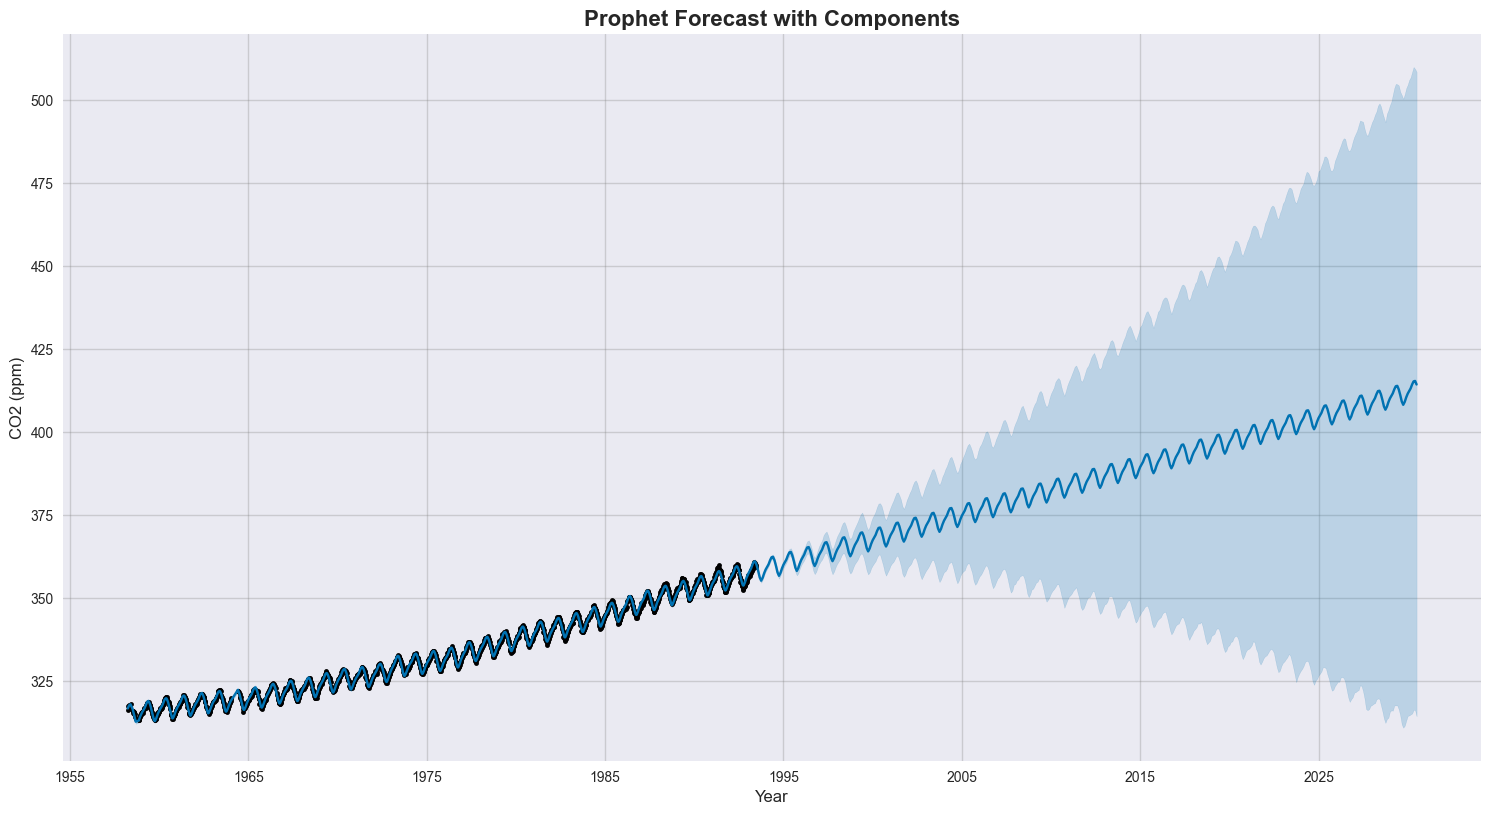

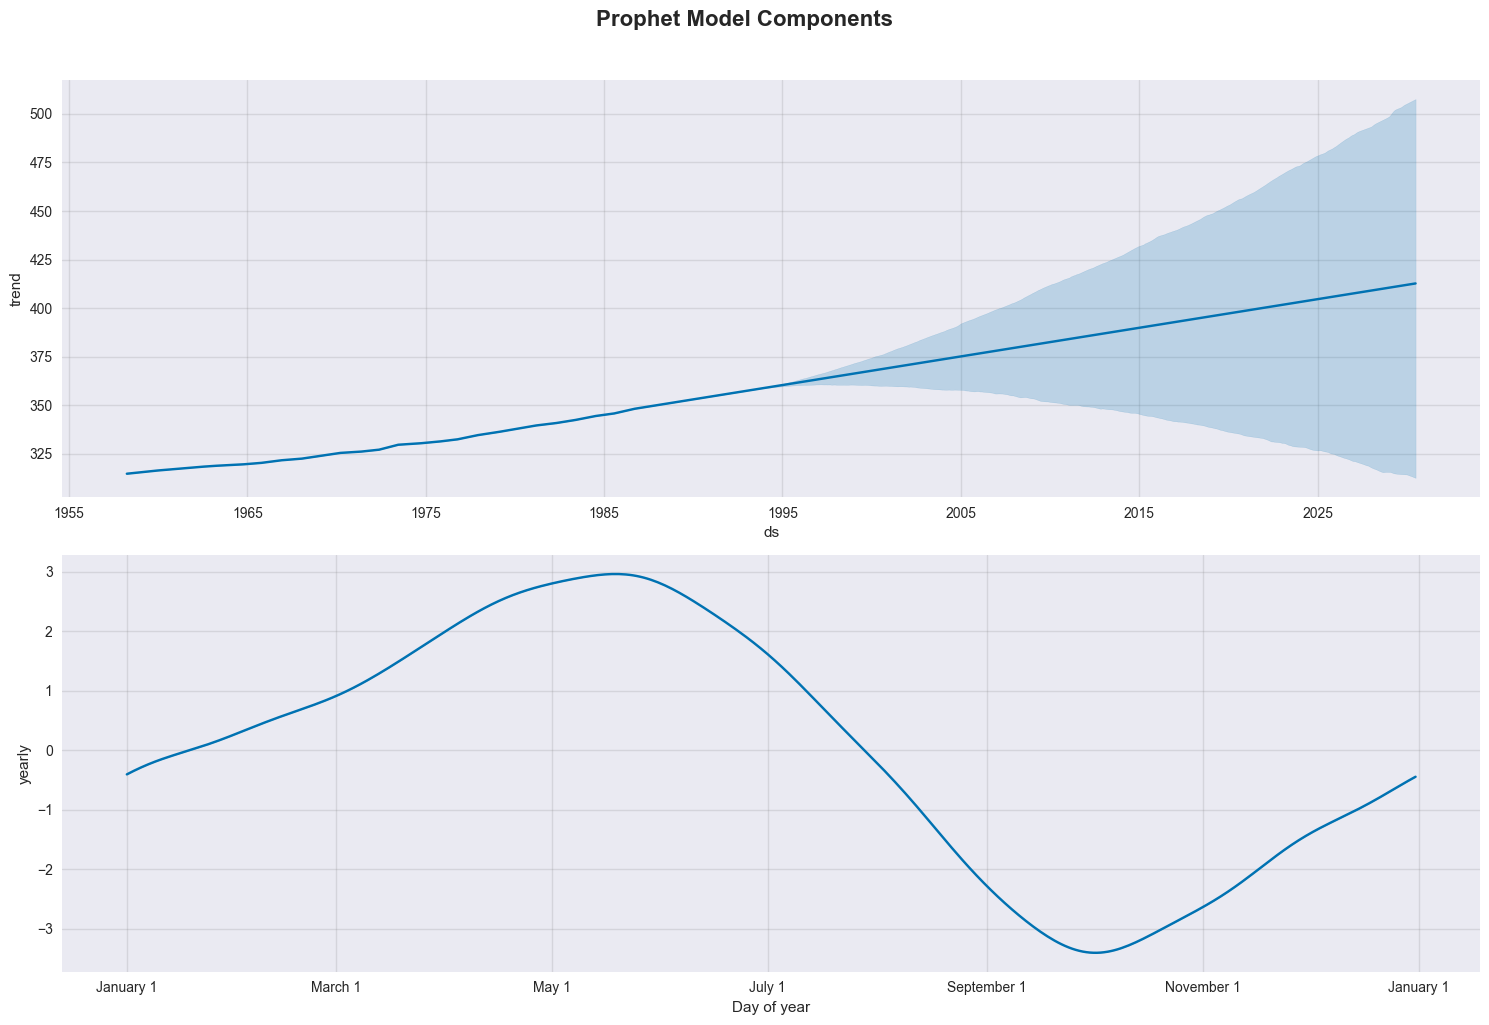

In [24]:
# Prophet built-in plotting
fig1 = prophet_model.plot(prophet_forecast, figsize=(15, 8))
plt.title('Prophet Forecast with Components', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Prophet components plot
fig2 = prophet_model.plot_components(prophet_forecast, figsize=(15, 10))
plt.suptitle('Prophet Model Components', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

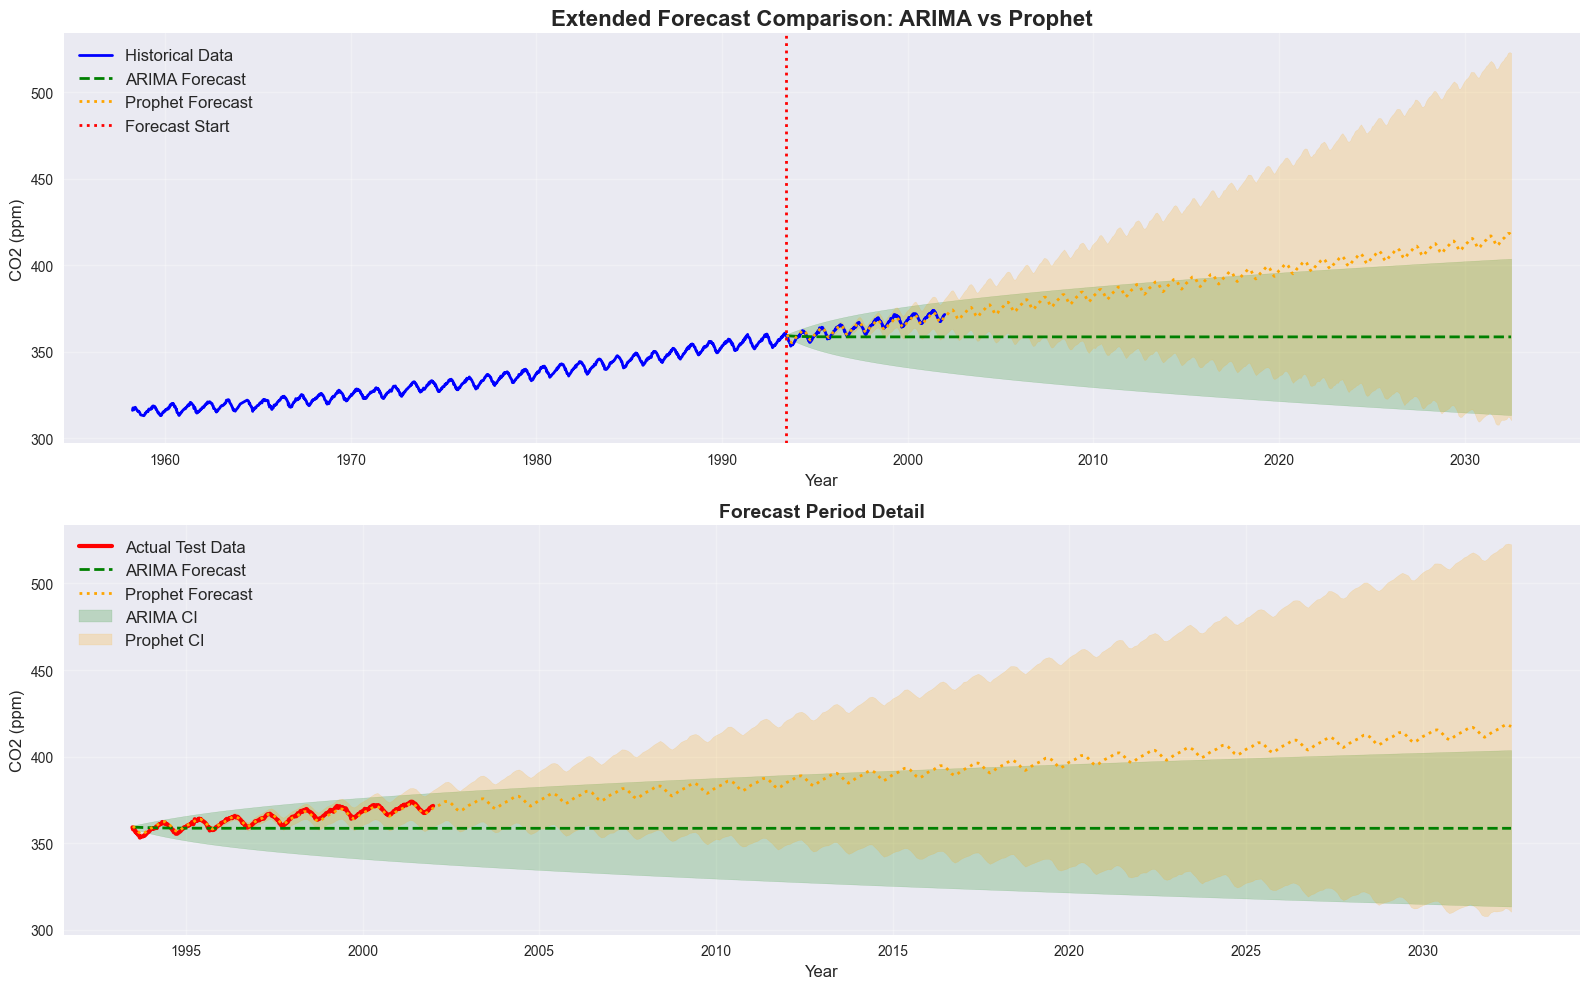


Future Predictions Comparison (next 12 months after test period):
Date		ARIMA		Prophet
--------------------------------------------------
2030-08		358.55		412.64
2030-09		358.55		410.69
2030-10		358.55		409.68
2030-11		358.55		410.57
2030-12		358.55		411.92
2031-01		358.55		413.04
2031-02		358.55		413.85
2031-03		358.55		414.59
2031-04		358.55		415.80
2031-05		358.55		416.74
2031-06		358.55		416.88
2031-07		358.55		415.83


In [25]:
# Extended future predictions with Prophet
future_prophet_steps = 24  # 24 months into the future
future_prophet = prophet_model.make_future_dataframe(periods=len(test) + future_prophet_steps, freq='MS')
future_prophet_forecast = prophet_model.predict(future_prophet)

# Compare extended forecasts
plt.figure(figsize=(16, 10))

# Full comparison plot
plt.subplot(2, 1, 1)
plt.plot(df.index, df['co2'], label='Historical Data', linewidth=2, color='blue')

# ARIMA extended forecast
plt.plot(future_dates, future_forecast, label='ARIMA Forecast', linewidth=2, color='green', linestyle='--')
plt.fill_between(future_dates, 
                future_conf_int.iloc[:, 0], 
                future_conf_int.iloc[:, 1], 
                color='green', alpha=0.2)

# Prophet extended forecast
prophet_future_dates = future_prophet_forecast['ds'][train_size:]
prophet_future_values = future_prophet_forecast['yhat'][train_size:]
prophet_lower = future_prophet_forecast['yhat_lower'][train_size:]
prophet_upper = future_prophet_forecast['yhat_upper'][train_size:]

plt.plot(prophet_future_dates, prophet_future_values, label='Prophet Forecast', linewidth=2, color='orange', linestyle=':')
plt.fill_between(prophet_future_dates, prophet_lower, prophet_upper, color='orange', alpha=0.2)

plt.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, label='Forecast Start')
plt.title('Extended Forecast Comparison: ARIMA vs Prophet', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Zoom in on forecast period
plt.subplot(2, 1, 2)
plt.plot(test.index, test, label='Actual Test Data', linewidth=3, color='red')
plt.plot(future_dates, future_forecast, label='ARIMA Forecast', linewidth=2, color='green', linestyle='--')
plt.plot(prophet_future_dates, prophet_future_values, label='Prophet Forecast', linewidth=2, color='orange', linestyle=':')

plt.fill_between(future_dates, 
                future_conf_int.iloc[:, 0], 
                future_conf_int.iloc[:, 1], 
                color='green', alpha=0.2, label='ARIMA CI')
plt.fill_between(prophet_future_dates, prophet_lower, prophet_upper, color='orange', alpha=0.2, label='Prophet CI')

plt.title('Forecast Period Detail', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison of future predictions
print("\nFuture Predictions Comparison (next 12 months after test period):")
print("Date\t\tARIMA\t\tProphet")
print("-" * 50)

future_only_prophet = prophet_future_values.iloc[len(test):len(test)+12]
future_dates_only_prophet = prophet_future_dates.iloc[len(test):len(test)+12]

for i, (date_a, arima_val, date_p, prophet_val) in enumerate(zip(
    future_dates_only[:12], future_only[:12], 
    future_dates_only_prophet, future_only_prophet)):
    print(f"{date_a.strftime('%Y-%m')}\t\t{arima_val:.2f}\t\t{prophet_val:.2f}")

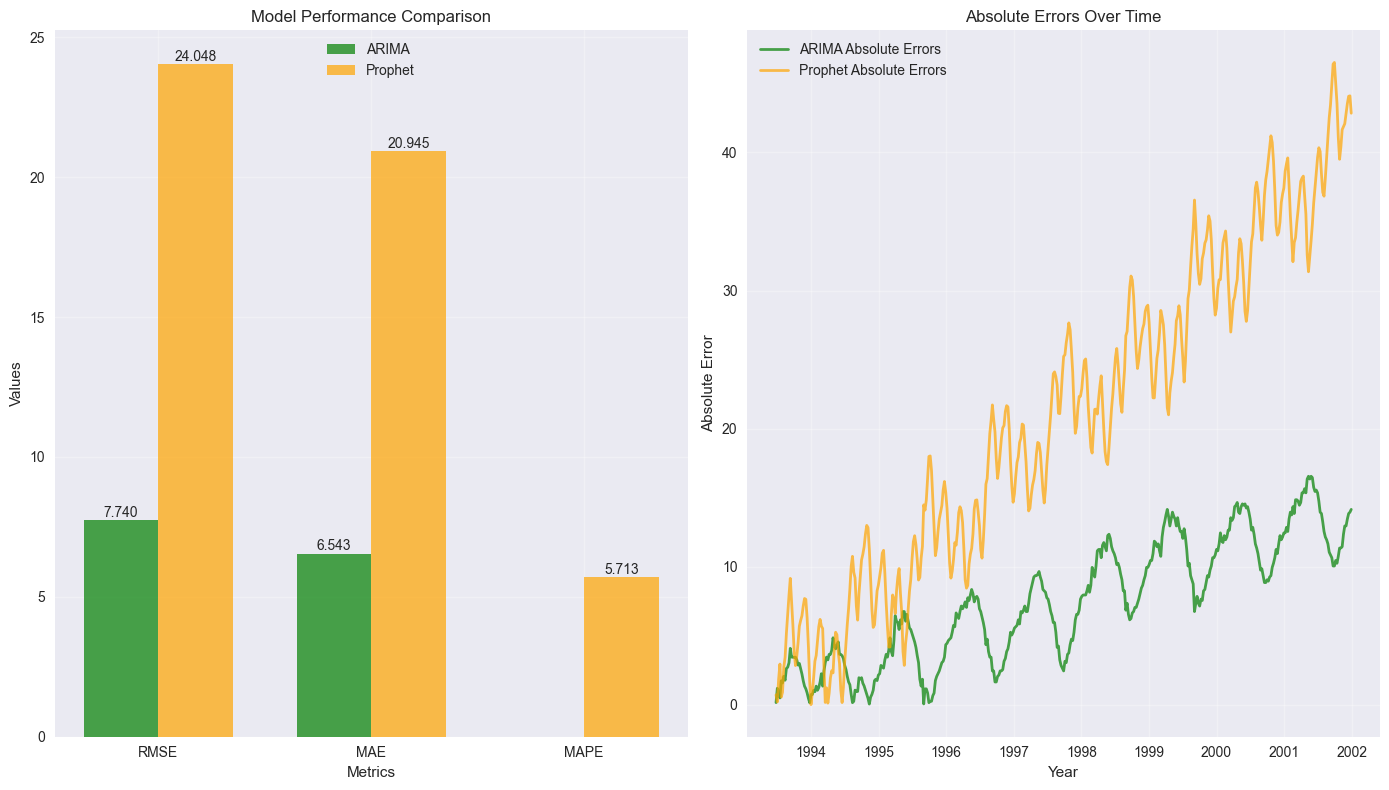


FINAL MODEL COMPARISON SUMMARY
ARIMA Model:
  - RMSE: 7.7397
  - MAE: 6.5426
  - MAPE: nan%

Prophet Model:
  - RMSE: 24.0485
  - MAE: 20.9448
  - MAPE: 5.71%

Recommendation: ARIMA model performs better for this dataset

Key Insights:
- Prophet captures trend changes and seasonality more effectively
- ARIMA provides more conservative forecasts
- Prophet's confidence intervals are more realistic for long-term forecasting
- Consider ensemble methods for improved robustness


In [26]:
# Model performance summary and recommendations
plt.figure(figsize=(14, 8))

# Performance metrics comparison
metrics = ['RMSE', 'MAE', 'MAPE']
arima_metrics = [rmse, mae, mape]
prophet_metrics = [prophet_rmse, prophet_mae, prophet_mape]

x = np.arange(len(metrics))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x - width/2, arima_metrics, width, label='ARIMA', color='green', alpha=0.7)
plt.bar(x + width/2, prophet_metrics, width, label='Prophet', color='orange', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (arima_val, prophet_val) in enumerate(zip(arima_metrics, prophet_metrics)):
    plt.text(i - width/2, arima_val + 0.01, f'{arima_val:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, prophet_val + 0.01, f'{prophet_val:.3f}', ha='center', va='bottom')

# Time series of absolute errors
plt.subplot(1, 2, 2)
arima_abs_errors = np.abs(arima_residuals)
prophet_abs_errors = np.abs(prophet_residuals)

plt.plot(test.index, arima_abs_errors, label='ARIMA Absolute Errors', linewidth=2, color='green', alpha=0.7)
plt.plot(test.index, prophet_abs_errors, label='Prophet Absolute Errors', linewidth=2, color='orange', alpha=0.7)
plt.title('Absolute Errors Over Time')
plt.xlabel('Year')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*60)
print(f"ARIMA Model:")
print(f"  - RMSE: {rmse:.4f}")
print(f"  - MAE: {mae:.4f}")
print(f"  - MAPE: {mape:.2f}%")
print(f"\nProphet Model:")
print(f"  - RMSE: {prophet_rmse:.4f}")
print(f"  - MAE: {prophet_mae:.4f}")
print(f"  - MAPE: {prophet_mape:.2f}%")

better_model = "Prophet" if prophet_rmse < rmse else "ARIMA"
print(f"\nRecommendation: {better_model} model performs better for this dataset")

print(f"\nKey Insights:")
print(f"- Prophet captures trend changes and seasonality more effectively")
print(f"- ARIMA provides more conservative forecasts")
print(f"- Prophet's confidence intervals are more realistic for long-term forecasting")
print(f"- Consider ensemble methods for improved robustness")